##Importing the required modules

In [1]:
from google.colab import  drive
drive.mount('./gdrive', force_remount=True)


Mounted at ./gdrive


In [2]:
import sys
import os
import shutil as sh

In [3]:
if not os.path.exists("/content/data"):
  os.mkdir("/content/data")
os.chdir('/content/gdrive/MyDrive/EVA S9/EVA/S12/Part A')

In [4]:
import torch
import torchvision
from torch import nn
from torch import optim
from torchsummary import summary
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision import models


In [5]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [6]:
import albumentations as A
from albumentations import pytorch
from AlbumentationTransformations import  AlbumentationTransforms as AT
from Data_Preparation import Prep_Data
from utils import DataProcessing
from regularizations import Regularizations
from train import *
from test import *
from graphs import Graphs
from GradCam import *
from LR_Finder import *
from Range_Test import *

### Data Preparation

In [7]:
data = Prep_Data("http://cs231n.stanford.edu/tiny-imagenet-200.zip", "/content/data/tiny-imagenet-200.zip")

In [8]:
data.download_url()

In [9]:
data.unzip_file()

'Unzipped file already exists'

In [10]:
data.split_dataset('/content', 70)

'Dataset has already been split'

In [11]:
class_dict = data.class_id_txt('/content/data/tiny-imagenet-200/words.txt')

## Maintaining Reproducability

In [12]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

##Loading the Dataset, performing image transformations and loading the DataLoader

In [13]:
data = DataProcessing('ImageFolder')

In [14]:
train_set = data.Dataset('/content/data/tiny-imagenet-200/new_train', True, AT([
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),                                      
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.5),
                                      A.HorizontalFlip(p = 0.5),
                                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                      A.pytorch.ToTensor()]))
test_set = data.Dataset('/content/data/tiny-imagenet-200/new_test', False, AT([ A.HorizontalFlip(p = 0.5), A.Normalize(mean=(0.5,0.5,0.5), std=(0.5, 0.5, 0.5)),
                                      A.pytorch.ToTensor()]))


In [15]:
train_set[0]

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.6941,  0.7176,  0.6235],
          [ 0.9294,  1.0000,  1.0000,  ...,  0.6706,  0.7020,  0.5922],
          [ 0.9294,  1.0000,  1.0000,  ...,  0.5294,  0.6471,  0.6314],
          ...,
          [-0.3176, -0.3255, -0.3098,  ..., -0.5216, -0.4431, -0.3098],
          [-0.2627, -0.2706, -0.2549,  ..., -0.3020, -0.3255, -0.2941],
          [-0.2706, -0.2706, -0.2627,  ..., -0.2000, -0.2941, -0.3333]],
 
         [[ 0.0510, -0.0039, -0.0275,  ...,  0.8118,  0.8745,  0.8275],
          [ 0.0745,  0.0039, -0.0275,  ...,  0.7804,  0.8588,  0.8196],
          [ 0.1608,  0.0902,  0.0745,  ...,  0.6549,  0.8196,  0.8588],
          ...,
          [-0.1373, -0.1451, -0.1059,  ..., -0.6078, -0.5294, -0.3961],
          [-0.0824, -0.0667, -0.0431,  ..., -0.3882, -0.4118, -0.3804],
          [-0.0902, -0.0667, -0.0431,  ..., -0.2863, -0.3804, -0.4196]],
 
         [[ 0.5922,  0.5765,  0.5765,  ...,  0.7882,  0.8588,  0.8039],
          [ 0.5216,  0.4824,

'n01443537'

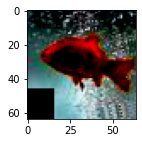

In [16]:
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(train_set[1][0],(1,2,0)))
train_set.classes[train_set[1][1]]


In [17]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader =  data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

## Taking a sneak peek at the dataset

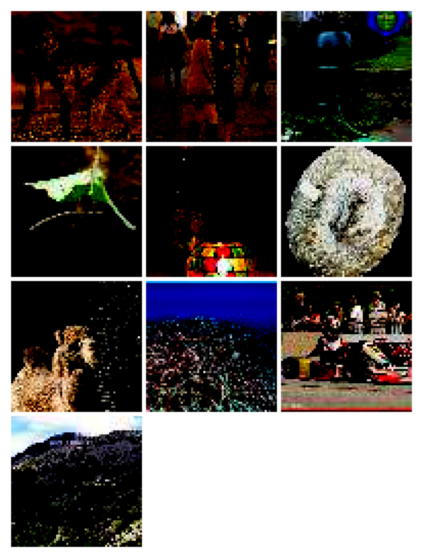

['n02486410', 'n03770439', 'n02795169', 'n02231487', 'n02823428', 'n01768244', 'n02437312', 'n09256479', 'n03444034', 'n09193705']


In [18]:
plt.figure(figsize=(10,10))
batch = next(iter(test_loader))
images, labels = batch
image, label = [],[]
for i in range(10):
  image.append(images[i])
  label.append(test_set.classes[labels[i]])

grid = torchvision.utils.make_grid(image, nrow=3, pad_value=1.0)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()
print(label)


## Viewing the parameter count used in the model

In [19]:
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = models.resnet18().to(device)
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

##LR Range Test


Learning rate search finished. See the graph with {finder_name}.plot()


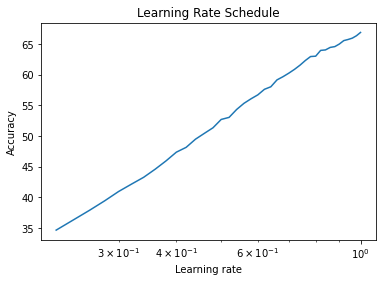

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4,momentum=0.9)
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, start_lr=1e-5, end_lr=1,epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [21]:
best_acc = lr_finder.best_acc
Best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, Best_lr))

Best Accuracy: 66.91714285714286
Best Learning Rate: 1.000036564042561


### Loading Optimizer and Scheduler

In [22]:
regularizer = Regularizations('SGD', model, 1., 0.9, Best_lr, len(train_loader), 0)

## Defining the main sequence of training and testing the model using the imported modules

In [23]:
def run(epochs, model, device, train_loader, regularizer, test_set, test_loader, class_dict):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  wrong_pred_data={'Images':[], 'Predicted':[], 'Actual':[]}  
  last_epoch = False
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, regularizer)
    if epoch == epochs - 1:
      last_epoch = True        
    test_loss, test_accuracy = test_model(model, device, test_set, test_loader, regularizer, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'], last_epoch, class_dict)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    #regularizer.optimizer_step(step=test_loss)
  return train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data

## Logging the results

In [24]:
train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data = run(50, model, device, train_loader, regularizer, test_set, test_loader, class_dict)

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.039428819 
Train Accuracy :  3.1157% 

Average Test Loss : 0.035739551 
Test Accuracy :  7.2550% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.034441540 
Train Accuracy :  8.9543% 

Average Test Loss : 0.032825144 
Test Accuracy :  11.4275% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.031623297 
Train Accuracy :  13.5114% 

Average Test Loss : 0.030239768 
Test Accuracy :  16.5275% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.029649255 
Train Accuracy :  17.1671% 

Average Test Loss : 0.029561500 
Test Accuracy :  18.1325% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.028240442 
Train Accuracy :  19.8543% 

Average Test Loss : 0.027741388 
Test Accuracy :  21.2975% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.027083741 
Train Accuracy :  22.1000% 

Average Test Loss : 0.028253772 
Test Accuracy :  21.5475% 


Epoch 7 in progress....

Epoch 

## Plotting the graph for the logged results

In [25]:
graphs = Graphs(1, 'Training Accuracy', 'Validation Accuracy')


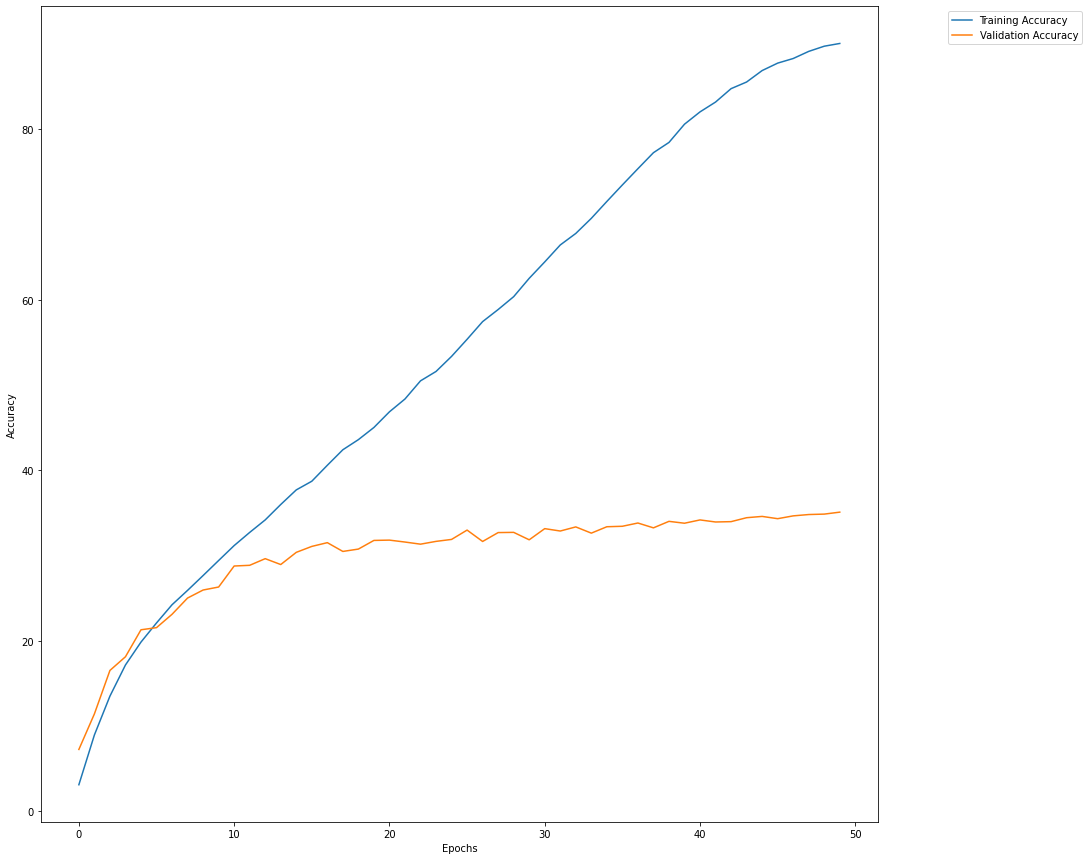

In [26]:
graphs.line_graph((15,15), train_accuracies, test_accuracies)


## Plotting 25 Misclassified Predictions

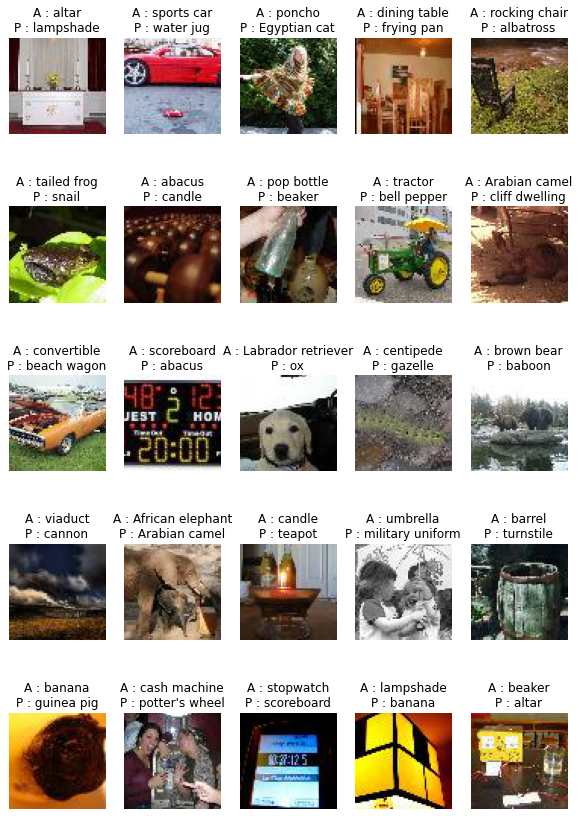

In [27]:
graphs.image_graph(5, 5, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'])

## GradCAM

In [28]:
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
GradCamView(wrong_pred_data,model,layers)

Output hidden; open in https://colab.research.google.com to view.